# Load packages and libraries

In [87]:
.libPaths()
.libPaths(new = c("/home/manuel.tardaguila/conda_envs/multiome_QC/lib/R/library"))
.libPaths()
# sessionInfo()

Sys.setenv(RETICULATE_PYTHON="/home/manuel.tardaguila/conda_envs/multiome_QC/bin/python")
library(reticulate)
reticulate::use_python("/home/manuel.tardaguila/conda_envs/multiome_QC/bin/python")
reticulate::use_condaenv("/home/manuel.tardaguila/conda_envs/multiome_QC")
reticulate::py_module_available(module='leidenalg')
reticulate::import('leidenalg')
suppressMessages(library("optparse"))
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(ggplot2))
suppressMessages(library(scDblFinder))
suppressMessages(library("tidyr"))
suppressMessages(library("tibble"))
suppressMessages(library("biovizBase"))
suppressMessages(library("patchwork"))
suppressMessages(library(glmGamPoi))
suppressMessages(library(SeuratData))
suppressMessages(library(SeuratDisk))
library(svglite)
library(RColorBrewer)




[1] "/home/manuel.tardaguila/conda_envs/multiome_QC/lib/R/library"

[1] "/home/manuel.tardaguila/conda_envs/multiome_QC/lib/R/library"

[1] TRUE

Module(leidenalg)

# Checkpoint after presentation

In [88]:
setwd("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/processing_outputs/")

adata<-readRDS(file="merged_processed_presentation_updated.rds")

## Read each of the files in Seurat

In [89]:
 adata_samp_1                 <- CreateSeuratObject(counts=Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/MCO_01326/outs/", 'raw_feature_bc_matrix.h5')))
  
 adata_samp_1$orig.ident<-'MCO_01326'

adata_samp_2                 <- CreateSeuratObject(counts=Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/MCO_01327/outs/", 'raw_feature_bc_matrix.h5')))
  
adata_samp_2$orig.ident<-'MCO_01327'


adata_samp_3                 <- CreateSeuratObject(counts=Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/MCO_01328/outs/", 'raw_feature_bc_matrix.h5')))
  
 
adata_samp_3$orig.ident<-'MCO_01328'

adata_samp_4                 <- CreateSeuratObject(counts=Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/MCO_01329/outs/", 'raw_feature_bc_matrix.h5')))
  
adata_samp_4$orig.ident<-'MCO_01329'


Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


## combine them in a single object

In [90]:
adatas<-list()

adatas[[1]]<-adata_samp_1
adatas[[2]]<-adata_samp_2
adatas[[3]]<-adata_samp_3
adatas[[4]]<-adata_samp_4

sample_array<-c('MCO_01326','MCO_01327','MCO_01328','MCO_01329')

merged = merge(x =adatas[[1]], y=adatas[2:4], add.cell.ids = sample_array )

merged[["RNA"]] <-JoinLayers(merged[["RNA"]])

merged


An object of class Seurat 
12 features across 434347 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

## Only use the barcodes that are part of my final object

In [91]:
joint.bcs <- intersect(colnames(adata), colnames(merged))

str(joint.bcs)

 chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" ...


In [92]:
merged_restricted <- subset(merged, cells = joint.bcs)

merged_restricted

An object of class Seurat 
12 features across 37492 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [93]:
hto_nocb_counts<-GetAssayData(
  merged_restricted,
  layer = c("counts"))+1

### Adding a pseudocount as seen in https://github.com/satijalab/seurat/issues/5640


In [94]:
str(hto_nocb_counts)

Formal class 'dgeMatrix' [package "Matrix"] with 4 slots
  ..@ Dim     : int [1:2] 12 37492
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" "MCO_01326_AAACAGCCACCAGGTT-1" "MCO_01326_AAACAGCCACGGTACT-1" "MCO_01326_AAACAGCCAGCCGCTA-1" ...
  ..@ x       : num [1:449904] 1 1 1 2 1 2 4 1 29 4 ...
  ..@ factors : list()


In [95]:
merged_restricted[["HTO_NOCB"]] <- CreateAssayObject(counts = hto_nocb_counts)

In [96]:
merged_restricted

An object of class Seurat 
24 features across 37492 samples within 2 assays 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO_NOCB

## normalize CLR

In [97]:
merged_restricted <- NormalizeData(merged_restricted, assay = "HTO_NOCB", normalization.method = "CLR")


Normalizing across features



## Demultiplex using HTO Demux

In [98]:
merged_restricted <- HTODemux(merged_restricted, assay = "HTO_NOCB", positive.quantile = 0.99)


Cutoff for GFP-chrGFP-WTA : 4 reads

Cutoff for GFP-chrGFP-WTB : 4 reads

Cutoff for GFP-chrGFP-WTC : 4 reads

Cutoff for GFP-chrGFP-rs1 : 5 reads

Cutoff for GFP-chrGFP-rs2 : 5 reads

Cutoff for GFP-chrGFP-rs3 : 7 reads

Cutoff for GFP-chrGFP-R882H1 : 5 reads

Cutoff for GFP-chrGFP-R882H2 : 4 reads

Cutoff for GFP-chrGFP-R882H3 : 4 reads

Cutoff for GFP-chrGFP-rs-R882H1 : 6 reads

Cutoff for GFP-chrGFP-rs-R882H2 : 5 reads

Cutoff for GFP-chrGFP-rs-R882H3 : 5 reads



In [99]:
str(merged_restricted@meta.data)

'data.frame':	37492 obs. of  11 variables:
 $ orig.ident                    : chr  "MCO_01326" "MCO_01326" "MCO_01326" "MCO_01326" ...
 $ nCount_RNA                    : num  41 4 14 19 30 6 32 18 34 32 ...
 $ nFeature_RNA                  : int  7 3 9 8 8 6 7 9 8 9 ...
 $ nCount_HTO_NOCB               : num  53 16 26 31 42 18 44 30 46 44 ...
 $ nFeature_HTO_NOCB             : int  12 12 12 12 12 12 12 12 12 12 ...
 $ HTO_NOCB_maxID                : chr  "GFP-chrGFP-R882H3" "GFP-chrGFP-rs-R882H3" "GFP-chrGFP-R882H1" "GFP-chrGFP-rs-R882H3" ...
 $ HTO_NOCB_secondID             : chr  "GFP-chrGFP-rs-R882H3" "GFP-chrGFP-rs-R882H2" "GFP-chrGFP-rs-R882H3" "GFP-chrGFP-R882H3" ...
 $ HTO_NOCB_margin               : num  1.4326 0.152 0.0979 0.3472 0.7371 ...
 $ HTO_NOCB_classification       : chr  "GFP-chrGFP-R882H3" "Negative" "Negative" "GFP-chrGFP-R882H3_GFP-chrGFP-rs-R882H3" ...
 $ HTO_NOCB_classification.global: chr  "Singlet" "Negative" "Negative" "Doublet" ...
 $ hash.ID                 

In [100]:
summary(merged_restricted@meta.data$hash.ID)

Doublet    GFP-chrGFP-R882H3             Negative 
               14894                 2009                 9183 
   GFP-chrGFP-R882H1 GFP-chrGFP-rs-R882H2 GFP-chrGFP-rs-R882H3 
                 714                  378                  445 
GFP-chrGFP-rs-R882H1       GFP-chrGFP-WTC    GFP-chrGFP-R882H2 
                 939                  223                   68 
      GFP-chrGFP-rs2       GFP-chrGFP-rs3       GFP-chrGFP-WTB 
                 598                 7120                  144 
      GFP-chrGFP-rs1       GFP-chrGFP-WTA 
                 692                   85

In [101]:
table(merged_restricted$HTO_NOCB_classification.global)


 Doublet Negative  Singlet 
   14894     9183    13415 

In [102]:
# Group cells based on the max HTO_NOCB signal
Idents(merged_restricted) <- "HTO_NOCB_maxID"
rp1<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[1], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp2<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[2], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp3<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[3], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp4<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[4], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

##

rp5<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[5], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp6<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[6], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp7<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[7], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp8<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[8], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

##

rp9<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[9], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp10<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[10], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp11<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[11], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

rp12<-RidgePlot(merged_restricted, assay = "HTO_NOCB", features = rownames(merged_restricted[["HTO_NOCB"]])[12], ncol = 1)+
             theme(legend.title = element_blank(),
                      legend.text = element_text(color="black", family="sans"),
                      legend.key.size = unit(0.25, 'cm'), #change legend key size
                      legend.key.height = unit(0.25, 'cm'), #change legend key height
                      legend.key.width = unit(0.25, 'cm'), #change legend key width
                      legend.position="hidden")

In [103]:
path_graphs<-"/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/processing_outputs/graphs/"

In [104]:
if (file.exists(path_graphs)){

    }else{

    dir.create(path_graphs)
    }

NULL

In [105]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_WTs_NO_CB.png', width =1050, height = 350)
rp1 | rp2 | rp3
dev.off()

Picking joint bandwidth of 0.0334

Picking joint bandwidth of 0.0389

Picking joint bandwidth of 0.039



png 
  2

In [106]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_rs_NO_CB.png', width =1050, height = 350)
rp4 | rp5 | rp6
dev.off()

Picking joint bandwidth of 0.0423

Picking joint bandwidth of 0.0469

Picking joint bandwidth of 0.0527



png 
  2

In [107]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_DNMT3A_NO_CB.png', width =1050, height = 350)
rp7 | rp8 | rp9
dev.off()

Picking joint bandwidth of 0.0606

Picking joint bandwidth of 0.032

Picking joint bandwidth of 0.0626



png 
  2

In [108]:
setwd(path_graphs)
png(file='Ridgeplot_assignation_Double_mutants_NO_CB.png', width =1050, height = 350)
rp10 | rp11 | rp12
dev.off()

Picking joint bandwidth of 0.055

Picking joint bandwidth of 0.0545

Picking joint bandwidth of 0.052



png 
  2

### Save this assignation

In [109]:
colnames(merged_restricted@meta.data)


str(row.names(merged_restricted@meta.data))

[1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "nCount_HTO_NOCB"               
 [5] "nFeature_HTO_NOCB"              "HTO_NOCB_maxID"                
 [7] "HTO_NOCB_secondID"              "HTO_NOCB_margin"               
 [9] "HTO_NOCB_classification"        "HTO_NOCB_classification.global"
[11] "hash.ID"

 chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" ...


In [110]:
path_save<-"/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/processing_outputs/"

In [111]:
setwd(path_save)

write.csv(merged_restricted@meta.data,"NO_CB_Barcodes_demux_assignation.csv")

# Add new Genotype Annotation to adata

In [112]:
colnames(adata@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "gex_raw_reads"                     "gex_mapped_reads"                 
[11] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[13] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[15] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[17] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[19] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[21] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[23] "gex_umis_count"                    "gex_genes_count"                  
[25] "atac_raw_reads"                    "atac_unmapped_reads"              
[27] "atac_lowmapq"                      "atac_dup_reads"                   
[29] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[31] "atac_fragments"                    "atac_TSS_fragments"               
[33] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[35] "TSS.enrichment"                    "TSS.percentile"                   
[37] "scDblFinder.class"                 "scDblFinder.score"                
[39] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[41] "scDblFinder.class_atac"            "scDblFinder.score_atac"           
[43] "scDblFinder.weighted_atac"         "scDblFinder.cxds_score_atac"      
[45] "No_assigned_GFPbc"                 "Assigned_GFPbc"                   
[47] "Assigned_GFPgenotype"              "DBL_comb"                         
[49] "amulet_nFrags"                     "amulet_uniqFrags"                 
[51] "amulet_nAbove2"                    "amulet_total.nAbove2"             
[53] "amulet_p.value"                    "amulet_q.value"                   
[55] "doublet_amulet"                    "nCount_SCT"                       
[57] "nFeature_SCT"                      "SCT.weight"                       
[59] "ATAC.weight"                       "wsnn_res.0.2"                     
[61] "seurat_clusters"                   "doublet"                          
[63] "wsnn_res.2"                        "wsnn_res.0.5"                     
[65] "wsnn_res.0.25"                     "CellTypist_BMA_label"             
[67] "CellTypist_BMA_conf_score"         "CellTypist_IPSCs_label"           
[69] "CellTypist_IPSCs_conf_score"       "CellTypist_BMA_label_filtered"    
[71] "CellTypist_IPSCs_label_filtered"   "time_point"                       
[73] "time"                              "nucleosome_signal"                
[75] "nucleosome_percentile"             "FRiP"                             
[77] "atac_pct_reads_in_peaks"           "my_anot"                          
[79] "FOI"                               "my_anot_updated"                  
[81] "majority_voting_BMA"               "majority_voting_iPSCs"            
[83] "current_anot"

In [113]:
summary(as.factor(adata@meta.data$Assigned_GFPbc))

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
              14               20               36              118 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             134             1629              105                9 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
             109              236               79               80 
Genotype missing 
           34935

In [126]:
adata<-AddMetaData(object= adata,
                  metadata= merged_restricted@meta.data$hash.ID,
                  col.name = "Assignation_demux_NO_CB")

In [127]:
summary(as.factor(adata@meta.data$Assignation_demux_NO_CB))

Doublet    GFP-chrGFP-R882H3             Negative 
               14897                 2010                 9187 
   GFP-chrGFP-R882H1 GFP-chrGFP-rs-R882H2 GFP-chrGFP-rs-R882H3 
                 717                  379                  445 
GFP-chrGFP-rs-R882H1       GFP-chrGFP-WTC    GFP-chrGFP-R882H2 
                 939                  223                   68 
      GFP-chrGFP-rs2       GFP-chrGFP-rs3       GFP-chrGFP-WTB 
                 598                 7120                  144 
      GFP-chrGFP-rs1       GFP-chrGFP-WTA 
                 692                   85

In [128]:
adata@meta.data$Assigned_GFPbc_demux_NO_CB<-gsub("^GFP-","",adata@meta.data$Assignation_demux_NO_CB)

In [129]:
adata@meta.data$Assigned_GFPbc_demux_NO_CB<-gsub("-","_",adata@meta.data$Assigned_GFPbc_demux_NO_CB)

In [130]:
summary(as.factor(adata@meta.data$Assigned_GFPbc_demux_NO_CB))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
             717               68             2010              939 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
             379              445              692              598 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
            7120               85              144              223 
         Doublet         Negative 
           14897             9187

In [131]:
adata@meta.data$Assigned_GFPbc_demux_NO_CB<-factor(adata@meta.data$Assigned_GFPbc_demux_NO_CB,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [134]:
summary(adata@meta.data$Assigned_GFPbc_demux_NO_CB)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
              85              144              223              692 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             598             7120              717               68 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
            2010              939              379              445 
         Doublet         Negative 
           14897             9187

In [135]:
summary(adata@meta.data$Assigned_GFPbc)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
              14               20               36              118 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             134             1629              105                9 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
             109              236               79               80 
Genotype missing 
           34935

## Compare results between both assignations

In [137]:
summary(droplevels(interaction(adata@meta.data$Assigned_GFPbc, adata@meta.data$Assigned_GFPbc_demux_NO_CB)))

chrGFP_WTA.chrGFP_WTA             chrGFP_rs3.chrGFP_WTA 
                                4                                 3 
      Genotype missing.chrGFP_WTA             chrGFP_WTB.chrGFP_WTB 
                               78                                 6 
            chrGFP_rs1.chrGFP_WTB             chrGFP_rs3.chrGFP_WTB 
                                1                                 3 
      chrGFP_rs_R882H1.chrGFP_WTB       Genotype missing.chrGFP_WTB 
                                1                               133 
            chrGFP_WTC.chrGFP_WTC             chrGFP_rs3.chrGFP_WTC 
                                9                                 8 
      Genotype missing.chrGFP_WTC             chrGFP_rs1.chrGFP_rs1 
                              206                                26 
            chrGFP_rs2.chrGFP_rs1             chrGFP_rs3.chrGFP_rs1 
                                1                                36 
      chrGFP_rs_R882H1.chrGFP_rs1       Genotype missing.chrGFP_rs1 
                                1                               628 
            chrGFP_rs1.chrGFP_rs2             chrGFP_rs2.chrGFP_rs2 
                                1                                28 
            chrGFP_rs3.chrGFP_rs2       Genotype missing.chrGFP_rs2 
                               22                               547 
            chrGFP_WTB.chrGFP_rs3             chrGFP_WTC.chrGFP_rs3 
                                1                                 5 
            chrGFP_rs1.chrGFP_rs3             chrGFP_rs2.chrGFP_rs3 
                               22                                20 
            chrGFP_rs3.chrGFP_rs3          chrGFP_R882H1.chrGFP_rs3 
                              836                                 5 
         chrGFP_R882H3.chrGFP_rs3       chrGFP_rs_R882H1.chrGFP_rs3 
                                1                                20 
      chrGFP_rs_R882H2.chrGFP_rs3       chrGFP_rs_R882H3.chrGFP_rs3 
                                2                                 5 
      Genotype missing.chrGFP_rs3          chrGFP_rs3.chrGFP_R882H1 
                             6203                                 7 
      chrGFP_R882H1.chrGFP_R882H1       chrGFP_R882H3.chrGFP_R882H1 
                               32                                 1 
   chrGFP_rs_R882H3.chrGFP_R882H1    Genotype missing.chrGFP_R882H1 
                                2                               675 
      chrGFP_R882H2.chrGFP_R882H2    Genotype missing.chrGFP_R882H2 
                                2                                66 
         chrGFP_rs2.chrGFP_R882H3          chrGFP_rs3.chrGFP_R882H3 
                                1                                 5 
      chrGFP_R882H1.chrGFP_R882H3       chrGFP_R882H3.chrGFP_R882H3 
                                1                                71 
   chrGFP_rs_R882H1.chrGFP_R882H3    Genotype missing.chrGFP_R882H3 
                                2                              1930 
      chrGFP_WTA.chrGFP_rs_R882H1       chrGFP_rs2.chrGFP_rs_R882H1 
                                1                                 1 
      chrGFP_rs3.chrGFP_rs_R882H1 chrGFP_rs_R882H1.chrGFP_rs_R882H1 
                               12                                78 
Genotype missing.chrGFP_rs_R882H1       chrGFP_WTA.chrGFP_rs_R882H2 
                              847                                 1 
      chrGFP_rs3.chrGFP_rs_R882H2    chrGFP_R882H1.chrGFP_rs_R882H2 
                                1                                 1 
chrGFP_rs_R882H2.chrGFP_rs_R882H2 Genotype missing.chrGFP_rs_R882H2 
                               28                               348 
      chrGFP_rs2.chrGFP_rs_R882H3       chrGFP_rs3.chrGFP_rs_R882H3 
                                1                                 3 
chrGFP_rs_R882H2.chrGFP_rs_R882H3 chrGFP_rs_R882H3.chrGFP_rs_R882H3 
                                1                                29 
Genotype m

## Show the genotype breakdown new

## Freq tables genotype factor vs time_point vs current_anot

### genotype clone line vs my anot updated vs time_point

In [140]:
met<-adata[[]]

In [141]:
colnames(met)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "gex_raw_reads"                     "gex_mapped_reads"                 
[11] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[13] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[15] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[17] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[19] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[21] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[23] "gex_umis_count"                    "gex_genes_count"                  
[25] "atac_raw_reads"                    "atac_unmapped_reads"              
[27] "atac_lowmapq"                      "atac_dup_reads"                   
[29] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[31] "atac_fragments"                    "atac_TSS_fragments"               
[33] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[35] "TSS.enrichment"                    "TSS.percentile"                   
[37] "scDblFinder.class"                 "scDblFinder.score"                
[39] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[41] "scDblFinder.class_atac"            "scDblFinder.score_atac"           
[43] "scDblFinder.weighted_atac"         "scDblFinder.cxds_score_atac"      
[45] "No_assigned_GFPbc"                 "Assigned_GFPbc"                   
[47] "Assigned_GFPgenotype"              "DBL_comb"                         
[49] "amulet_nFrags"                     "amulet_uniqFrags"                 
[51] "amulet_nAbove2"                    "amulet_total.nAbove2"             
[53] "amulet_p.value"                    "amulet_q.value"                   
[55] "doublet_amulet"                    "nCount_SCT"                       
[57] "nFeature_SCT"                      "SCT.weight"                       
[59] "ATAC.weight"                       "wsnn_res.0.2"                     
[61] "seurat_clusters"                   "doublet"                          
[63] "wsnn_res.2"                        "wsnn_res.0.5"                     
[65] "wsnn_res.0.25"                     "CellTypist_BMA_label"             
[67] "CellTypist_BMA_conf_score"         "CellTypist_IPSCs_label"           
[69] "CellTypist_IPSCs_conf_score"       "CellTypist_BMA_label_filtered"    
[71] "CellTypist_IPSCs_label_filtered"   "time_point"                       
[73] "time"                              "nucleosome_signal"                
[75] "nucleosome_percentile"             "FRiP"                             
[77] "atac_pct_reads_in_peaks"           "my_anot"                          
[79] "FOI"                               "my_anot_updated"                  
[81] "majority_voting_BMA"               "majority_voting_iPSCs"            
[83] "current_anot"                      "Assignation_demux_NO_CB"          
[85] "Assigned_GFPbc_demux_NO_CB"

In [142]:
met.dt<-data.table(met,key=c("time_point","current_anot","Assigned_GFPbc_demux_NO_CB"))

In [143]:
#str(met.dt)

In [144]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)
#Freq.table

In [145]:
met.dt<-data.table(met, key=c("time_point","current_anot"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)
#Freq.TOTAL

In [146]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","current_anot"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [147]:
str(Freq.table)

'data.frame':	189 obs. of  6 variables:
 $ time_point                : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot              : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_demux_NO_CB: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 2 3 4 5 6 7 8 9 10 11 ...
 $ Freq                      : int  1 2 1 2 2 17 3 70 6 4 ...
 $ TOTAL                     : int  380 380 380 380 380 380 380 380 380 380 ...
 $ Perc                      : num  0.26 0.53 0.26 0.53 0.53 ...


In [148]:
met.dt<-data.table(met, key=c("time_point"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)

Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by="time_point")

#Freq.table

In [149]:
str(Freq.table)

'data.frame':	189 obs. of  7 variables:
 $ time_point                : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot              : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_demux_NO_CB: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 2 3 4 5 6 7 8 9 10 11 ...
 $ Freq                      : int  1 2 1 2 2 17 3 70 6 4 ...
 $ TOTAL                     : int  380 380 380 380 380 380 380 380 380 380 ...
 $ Perc                      : num  0.26 0.53 0.26 0.53 0.53 ...
 $ ntime                     : int  13520 13520 13520 13520 13520 13520 13520 13520 13520 13520 ...


In [150]:
Freq.TOTAL<-merge(Freq.TOTAL,
                  Freq.time_point,
                  by="time_point")

In [151]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 100),]

str(Freq.table_filtered)

'data.frame':	157 obs. of  7 variables:
 $ time_point                : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot              : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_demux_NO_CB: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 2 3 4 5 6 7 8 9 10 11 ...
 $ Freq                      : int  1 2 1 2 2 17 3 70 6 4 ...
 $ TOTAL                     : int  380 380 380 380 380 380 380 380 380 380 ...
 $ Perc                      : num  0.26 0.53 0.26 0.53 0.53 ...
 $ ntime                     : int  13520 13520 13520 13520 13520 13520 13520 13520 13520 13520 ...


In [152]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [153]:
library(forcats)
library(cowplot)


Attaching package: 'cowplot'


The following object is masked from 'package:patchwork':

    align_plots


The following object is masked from 'package:ggpubr':

    get_legend




-------------------------------------->	0 25 50 75 100


Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


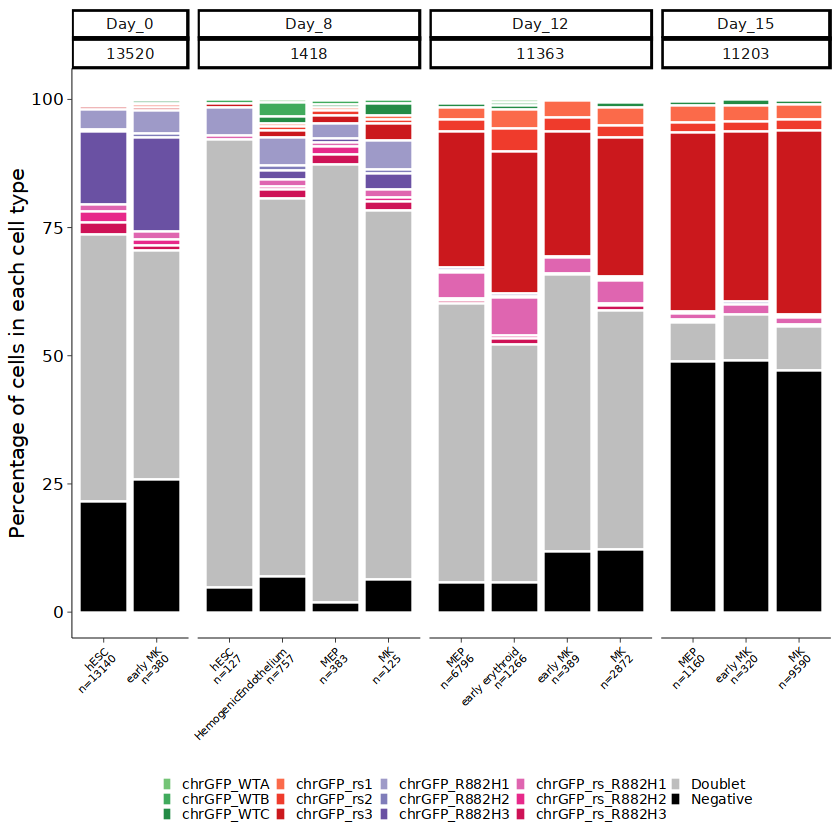

In [154]:
#### Stacked Graph #2---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(current_anot, "\n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(current_anot)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=Assigned_GFPbc_demux_NO_CB)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(. ~ time_point+ntime, scales='free_x', space='free_x', switch="y", labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime)))+   
    scale_x_discrete(name="current_anot", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=6,vjust=1,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [155]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_time_point_current_anot_vs_Assigned_GFPbc_demux_NO_C",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png",
        width=12, height=6)
}

# Read each of the cellbender corrected files in Seurat

In [160]:
 

  cb_counts = Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/processing_outputs/MCO_01326/", 'cellbender_gex_seurat.h5'))

  cat("cb_counts_0\n")
  cat(str(cb_counts))
  cat("\n")

  adata_samp_1_CB = CreateSeuratObject(counts = cb_counts)

adata_samp_1_CB$orig.ident<-'MCO_01326'


cb_counts_0
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:61611] 4 5 6 7 8 9 10 6 8 9 ...
  ..@ p       : int [1:132581] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ Dim     : int [1:2] 12 132580
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP_chrGFP_WTA" "GFP_chrGFP_WTB" "GFP_chrGFP_WTC" "GFP_chrGFP_rs1" ...
  .. ..$ : chr [1:132580] "AAACAGCCAAAGCCTC-1" "AAACAGCCAAAGGTAC-1" "AAACAGCCAAATACCT-1" "AAACAGCCAACACCTA-1" ...
  ..@ x       : num [1:61611] 1 1 1 1 17 1 1 1 26 2 ...
  ..@ factors : list()



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [161]:
cb_counts = Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/processing_outputs/MCO_01327/", 'cellbender_gex_seurat.h5'))

  cat("cb_counts_0\n")
  cat(str(cb_counts))
  cat("\n")

  adata_samp_2_CB = CreateSeuratObject(counts = cb_counts)

adata_samp_2_CB$orig.ident<-'MCO_01327'

cb_counts_0
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:2994] 0 1 2 3 4 5 6 7 8 9 ...
  ..@ p       : int [1:77970] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ Dim     : int [1:2] 12 77969
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP_chrGFP_WTA" "GFP_chrGFP_WTB" "GFP_chrGFP_WTC" "GFP_chrGFP_rs1" ...
  .. ..$ : chr [1:77969] "AAACAGCCAAACAACA-1" "AAACAGCCAAACCTTG-1" "AAACAGCCAAAGGTAC-1" "AAACAGCCAACACCTA-1" ...
  ..@ x       : num [1:2994] 1 2 15 4 7 11 6 5 37 3 ...
  ..@ factors : list()



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [162]:
cb_counts = Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/processing_outputs/MCO_01328/", 'cellbender_gex_seurat.h5'))

  cat("cb_counts_0\n")
  cat(str(cb_counts))
  cat("\n")

  adata_samp_3_CB = CreateSeuratObject(counts = cb_counts)

adata_samp_3_CB$orig.ident<-'MCO_01328'

cb_counts_0
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:63072] 3 4 5 9 3 5 9 11 2 3 ...
  ..@ p       : int [1:128113] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ Dim     : int [1:2] 12 128112
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP_chrGFP_WTA" "GFP_chrGFP_WTB" "GFP_chrGFP_WTC" "GFP_chrGFP_rs1" ...
  .. ..$ : chr [1:128112] "AAACAGCCAAACATAG-1" "AAACAGCCAAACTAAG-1" "AAACAGCCAAAGCGCA-1" "AAACAGCCAAAGCTAA-1" ...
  ..@ x       : num [1:63072] 1 3 8 21 3 7 2 2 2 1 ...
  ..@ factors : list()



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [163]:
cb_counts = Read10X_h5(file.path("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/GEX_reseq/alignment/cellranger/processing_outputs/MCO_01329/", 'cellbender_gex_seurat.h5'))

  cat("cb_counts_0\n")
  cat(str(cb_counts))
  cat("\n")

  adata_samp_4_CB = CreateSeuratObject(counts = cb_counts)

adata_samp_4_CB$orig.ident<-'MCO_01329'

cb_counts_0
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:21538] 3 9 4 5 2 4 5 9 10 11 ...
  ..@ p       : int [1:95687] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ Dim     : int [1:2] 12 95686
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP_chrGFP_WTA" "GFP_chrGFP_WTB" "GFP_chrGFP_WTC" "GFP_chrGFP_rs1" ...
  .. ..$ : chr [1:95686] "AAACAGCCAAACCTTG-1" "AAACAGCCAACAACAA-1" "AAACAGCCAACCTGGT-1" "AAACAGCCAACTAGAA-1" ...
  ..@ x       : num [1:21538] 5 2 2 3 1 56 23 4 2 1 ...
  ..@ factors : list()



Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


## combine them in a single object

In [164]:
adatas<-list()

adatas[[1]]<-adata_samp_1_CB
adatas[[2]]<-adata_samp_2_CB
adatas[[3]]<-adata_samp_3_CB
adatas[[4]]<-adata_samp_4_CB

sample_array<-c('MCO_01326','MCO_01327','MCO_01328','MCO_01329')

merged_CB = merge(x =adatas[[1]], y=adatas[2:4], add.cell.ids = sample_array )

merged_CB[["RNA"]] <-JoinLayers(merged_CB[["RNA"]])

merged_CB


An object of class Seurat 
12 features across 434347 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

## Only use the barcodes that are part of my final object

In [165]:
joint.bcs <- intersect(colnames(adata), colnames(merged_CB))

str(joint.bcs)

 chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" ...


In [166]:
merged_CB_restricted <- subset(merged_CB, cells = joint.bcs)

merged_CB_restricted

An object of class Seurat 
12 features across 37492 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [168]:
hto_cb_counts<-GetAssayData(
  merged_CB_restricted,
  layer = c("counts"))+1

### Adding a pseudocount as seen in https://github.com/satijalab/seurat/issues/5640


In [169]:
str(hto_cb_counts)

Formal class 'dgeMatrix' [package "Matrix"] with 4 slots
  ..@ Dim     : int [1:2] 12 37492
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" "MCO_01326_AAACAGCCACCAGGTT-1" "MCO_01326_AAACAGCCACGGTACT-1" "MCO_01326_AAACAGCCAGCCGCTA-1" ...
  ..@ x       : num [1:449904] 1 1 1 1 1 1 2 1 27 3 ...
  ..@ factors : list()


In [170]:
merged_CB_restricted[["HTO_CB"]] <- CreateAssayObject(counts = hto_cb_counts)

In [171]:
merged_CB_restricted

An object of class Seurat 
24 features across 37492 samples within 2 assays 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO_CB

## normalize CLR

In [172]:
merged_CB_restricted <- NormalizeData(merged_CB_restricted, assay = "HTO_CB", normalization.method = "CLR")


Normalizing across features



## Demultiplex using HTO Demux

In [173]:
merged_CB_restricted <- HTODemux(merged_CB_restricted, assay = "HTO_CB", positive.quantile = 0.99)


Cutoff for GFP-chrGFP-WTA : 4 reads

Cutoff for GFP-chrGFP-WTB : 4 reads

Cutoff for GFP-chrGFP-WTC : 4 reads

Cutoff for GFP-chrGFP-rs1 : 4 reads

Cutoff for GFP-chrGFP-rs2 : 4 reads

Cutoff for GFP-chrGFP-rs3 : 4 reads

Cutoff for GFP-chrGFP-R882H1 : 6 reads

Cutoff for GFP-chrGFP-R882H2 : 4 reads

Cutoff for GFP-chrGFP-R882H3 : 4 reads

Cutoff for GFP-chrGFP-rs-R882H1 : 4 reads

Cutoff for GFP-chrGFP-rs-R882H2 : 4 reads

Cutoff for GFP-chrGFP-rs-R882H3 : 4 reads



In [174]:
summary(merged_CB_restricted@meta.data$hash.ID)

Doublet    GFP-chrGFP-R882H3             Negative 
               11574                  938                14948 
      GFP-chrGFP-rs1    GFP-chrGFP-R882H1 GFP-chrGFP-rs-R882H2 
                 622                  607                  513 
GFP-chrGFP-rs-R882H3       GFP-chrGFP-WTC       GFP-chrGFP-rs3 
                 645                  215                 5511 
   GFP-chrGFP-R882H2 GFP-chrGFP-rs-R882H1       GFP-chrGFP-rs2 
                  79                 1097                  493 
      GFP-chrGFP-WTA       GFP-chrGFP-WTB 
                  98                  152

# Add CB to Genotype Annotation to adata

In [176]:
adata<-AddMetaData(object= adata,
                  metadata= merged_CB_restricted@meta.data$hash.ID,
                  col.name = "Assignation_demux_CB")

In [177]:
summary(as.factor(adata@meta.data$Assignation_demux_CB))

Doublet    GFP-chrGFP-R882H3             Negative 
               11575                  939                14953 
      GFP-chrGFP-rs1    GFP-chrGFP-R882H1 GFP-chrGFP-rs-R882H2 
                 623                  610                  514 
GFP-chrGFP-rs-R882H3       GFP-chrGFP-WTC       GFP-chrGFP-rs3 
                 645                  215                 5511 
   GFP-chrGFP-R882H2 GFP-chrGFP-rs-R882H1       GFP-chrGFP-rs2 
                  79                 1097                  493 
      GFP-chrGFP-WTA       GFP-chrGFP-WTB 
                  98                  152

In [178]:
adata@meta.data$Assigned_GFPbc_demux_CB<-gsub("^GFP-","",adata@meta.data$Assignation_demux_CB)

In [179]:
adata@meta.data$Assigned_GFPbc_demux_CB<-gsub("-","_",adata@meta.data$Assigned_GFPbc_demux_CB)

In [180]:
summary(as.factor(adata@meta.data$Assigned_GFPbc_demux_CB))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
             610               79              939             1097 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
             514              645              623              493 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
            5511               98              152              215 
         Doublet         Negative 
           11575            14953

In [181]:
adata@meta.data$Assigned_GFPbc_demux_CB<-factor(adata@meta.data$Assigned_GFPbc_demux_CB,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [182]:
summary(adata@meta.data$Assigned_GFPbc_demux_CB)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
              98              152              215              623 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             493             5511              610               79 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
             939             1097              514              645 
         Doublet         Negative 
           11575            14953

## Compare results between demux pre and post CB assignations

In [183]:
summary(droplevels(interaction(adata@meta.data$Assigned_GFPbc_demux_NO_CB, adata@meta.data$Assigned_GFPbc_demux_CB)))

Doublet.Doublet                 Negative.Negative 
                            11164                              9106 
            chrGFP_rs3.chrGFP_rs3               chrGFP_rs3.Negative 
                             5228                              1482 
                 Doublet.Negative            chrGFP_R882H3.Negative 
                             1385                              1334 
chrGFP_rs_R882H1.chrGFP_rs_R882H1       chrGFP_R882H3.chrGFP_R882H3 
                              701                               609 
            chrGFP_rs1.chrGFP_rs1            chrGFP_R882H1.Negative 
                              458                               457 
         Doublet.chrGFP_rs_R882H3             chrGFP_rs2.chrGFP_rs2 
                              396                               380 
            Doublet.chrGFP_R882H1             Doublet.chrGFP_R882H3 
                              341                               325 
         Doublet.chrGFP_rs_R882H1                chrGFP_rs3.Doublet 
                              325                               315 
         Doublet.chrGFP_rs_R882H2       chrGFP_R882H1.chrGFP_R882H1 
                              298                               247 
chrGFP_rs_R882H3.chrGFP_rs_R882H3         chrGFP_rs_R882H1.Negative 
                              214                               212 
        chrGFP_rs_R882H3.Negative               chrGFP_rs1.Negative 
                              212                               202 
chrGFP_rs_R882H2.chrGFP_rs_R882H2                Doublet.chrGFP_rs3 
                              193                               177 
              chrGFP_rs2.Negative         chrGFP_rs_R882H2.Negative 
                              169                               169 
               Doublet.chrGFP_rs1             chrGFP_WTC.chrGFP_WTC 
                              149                               132 
               Doublet.chrGFP_rs2               chrGFP_WTB.Negative 
                              106                                83 
              chrGFP_WTC.Negative                Doublet.chrGFP_WTB 
                               80                                78 
               Doublet.chrGFP_WTC             chrGFP_WTB.chrGFP_WTB 
                               67                                60 
            chrGFP_WTA.chrGFP_WTA             Doublet.chrGFP_R882H2 
                               58                                48 
            chrGFP_R882H3.Doublet             chrGFP_rs2.chrGFP_rs3 
                               43                                39 
        Negative.chrGFP_rs_R882H1                Doublet.chrGFP_WTA 
                               39                                38 
           chrGFP_R882H2.Negative       chrGFP_R882H2.chrGFP_R882H2 
                               37                                29 
              chrGFP_WTA.Negative          chrGFP_rs3.chrGFP_R882H1 
                               25                                20 
            chrGFP_rs1.chrGFP_rs3         Negative.chrGFP_rs_R882H3 
                               19                                17 
      chrGFP_rs3.chrGFP_rs_R882H1         Negative.chrGFP_rs_R882H2 
                               16                                16 
            chrGFP_rs3.chrGFP_WTC       chrGFP_rs_R882H1.chrGFP_rs3 
                               14                                14 
            chrGFP_rs3.chrGFP_WTB          chrGFP_rs_R882H2.Doublet 
                               13                                13 
      chrGFP_rs3.chrGFP_rs_R882H3          chrGFP_rs_R882H3.Doublet 
                               12                                12 
            chrGFP_rs3.chrGFP_rs1    chrGFP_R882H3.chrGFP_rs_R882H1 
                               11                                10 
         chrGFP_rs_R882H1.Doublet          chrGFP_R882H3.chrGFP_rs3 
                                9                                 7 
               c

## Compare results between Paola from GEX and demux pre and post CB assignations

In [184]:
summary(droplevels(interaction(adata@meta.data$Assigned_GFPbc, adata@meta.data$Assigned_GFPbc_demux_NO_CB, adata@meta.data$Assigned_GFPbc_demux_CB, sep="...")))

Genotype missing...Doublet...Doublet 
                                                 10781 
                Genotype missing...Negative...Negative 
                                                  8456 
            Genotype missing...chrGFP_rs3...chrGFP_rs3 
                                                  4554 
                 Genotype missing...Doublet...Negative 
                                                  1357 
           Genotype missing...chrGFP_R882H3...Negative 
                                                  1313 
              Genotype missing...chrGFP_rs3...Negative 
                                                  1283 
Genotype missing...chrGFP_rs_R882H1...chrGFP_rs_R882H1 
                                                   626 
                  chrGFP_rs3...chrGFP_rs3...chrGFP_rs3 
                                                   624 
      Genotype missing...chrGFP_R882H3...chrGFP_R882H3 
                                                   554 
                      chrGFP_rs3...Negative...Negative 
                                                   503 
           Genotype missing...chrGFP_R882H1...Negative 
                                                   439 
            Genotype missing...chrGFP_rs1...chrGFP_rs1 
                                                   414 
         Genotype missing...Doublet...chrGFP_rs_R882H3 
                                                   373 
            Genotype missing...chrGFP_rs2...chrGFP_rs2 
                                                   346 
            Genotype missing...Doublet...chrGFP_R882H1 
                                                   321 
            Genotype missing...Doublet...chrGFP_R882H3 
                                                   316 
         Genotype missing...Doublet...chrGFP_rs_R882H1 
                                                   298 
               Genotype missing...chrGFP_rs3...Doublet 
                                                   283 
         Genotype missing...Doublet...chrGFP_rs_R882H2 
                                                   279 
      Genotype missing...chrGFP_R882H1...chrGFP_R882H1 
                                                   223 
        Genotype missing...chrGFP_rs_R882H3...Negative 
                                                   204 
        Genotype missing...chrGFP_rs_R882H1...Negative 
                                                   195 
Genotype missing...chrGFP_rs_R882H3...chrGFP_rs_R882H3 
                                                   189 
              Genotype missing...chrGFP_rs1...Negative 
                                                   182 
                    chrGFP_rs3...chrGFP_rs3...Negative 
                                                   174 
Genotype missing...chrGFP_rs_R882H2...chrGFP_rs_R882H2 
                                                   170 
               Genotype missing...Doublet...chrGFP_rs3 
                                                   164 
        Genotype missing...chrGFP_rs_R882H2...Negative 
                                                   161 
                        chrGFP_rs3...Doublet...Doublet 
                                                   154 
              Genotype missing...chrGFP_rs2...Negative 
                                                   154 
               Genotype missing...Doublet...chrGFP_rs1 
                                                   126 
            Genotype missing...chrGFP_WTC...chrGFP_WTC 
                                                   121 
               Genotype missing...Doublet...chrGFP_rs2 
                                                    95 
              Genotype missing...chrGFP_WTB...Negative 
                                                    79 
              Genotype missing...chrGFP_WTC...Negative 
                                                    74 
               Genotype missing...Doublet...chrGFP_WTB 
                                          

# Create an integrative genotype assignation

In [216]:
adata@meta.data$Assigned_GFPbc_integral<-NA

## 1. First keep the genotype assignation from the GEX library using Paola's criteria (3 UMIs and no conflicting barcodes)

In [217]:
indx.keep<-which(adata@meta.data$Assigned_GFPbc != 'Genotype missing')

str(indx.keep)

indx.change<-which(adata@meta.data$Assigned_GFPbc == 'Genotype missing')

str(indx.change)

 int [1:2569] 11 36 96 191 229 237 340 341 342 349 ...
 int [1:34935] 1 2 3 4 5 6 7 8 9 10 ...


In [218]:
adata@meta.data$Assigned_GFPbc_integral[indx.keep]<-as.character(adata@meta.data$Assigned_GFPbc[indx.keep])

## 2. Inside the 'Genotype missing' use the targeted amplification data. For the targeted amplification library use the assignation of Demux without CellBender except for the Doublets label

In [219]:
indx.keep.2<-which(adata@meta.data$Assigned_GFPbc == 'Genotype missing' & adata@meta.data$Assigned_GFPbc_demux_NO_CB != 'Doublet')

str(indx.keep.2)

indx.change.2<-which(adata@meta.data$Assigned_GFPbc == 'Genotype missing' & adata@meta.data$Assigned_GFPbc_demux_NO_CB == 'Doublet')

str(indx.change.2)

 int [1:20603] 1 2 3 6 7 8 10 12 14 15 ...
 int [1:14332] 4 5 9 13 16 18 19 20 23 24 ...


In [220]:
adata@meta.data$Assigned_GFPbc_integral[indx.keep.2]<-as.character(adata@meta.data$Assigned_GFPbc_demux_NO_CB[indx.keep.2])

## 3 Inside the 'Doublet' use the Cell Bender correction

In [221]:
adata@meta.data$Assigned_GFPbc_integral[indx.change.2]<-as.character(adata@meta.data$Assigned_GFPbc_demux_CB[indx.change.2])

In [222]:
length(indx.keep)+length(indx.keep.2)+length(indx.change.2)

[1] 37504

In [223]:
dim(adata@meta.data)[1]

[1] 37504

## Order the factor

In [224]:
summary(as.factor(adata@meta.data$Assigned_GFPbc_integral))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
            1101              123             2355             1381 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
             706              864              872              776 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
            7996              130              226              305 
         Doublet         Negative 
           10781             9888

In [226]:
#summary(droplevels(as.factor(adata@meta.data$Assigned_GFPbc[is.na(adata@meta.data$Assigned_GFPbc_integral)])))

In [227]:
#summary(droplevels(as.factor(adata@meta.data$Assigned_GFPbc_demux_NO_CB[is.na(adata@meta.data$Assigned_GFPbc_integral)])))

In [228]:
#summary(droplevels(as.factor(adata@meta.data$Assigned_GFPbc_demux_CB[is.na(adata@meta.data$Assigned_GFPbc_integral)])))

In [229]:
adata@meta.data$Assigned_GFPbc_integral<-factor(adata@meta.data$Assigned_GFPbc_integral,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [230]:
summary(adata@meta.data$Assigned_GFPbc_integral)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
             130              226              305              872 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
             776             7996             1101              123 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
            2355             1381              706              864 
         Doublet         Negative 
           10781             9888

## Show the genotype breakdown new

## Freq tables genotype factor vs time_point vs current_anot

### genotype clone line vs my anot updated vs time_point

In [231]:
met<-adata[[]]

In [232]:
colnames(met)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "gex_raw_reads"                     "gex_mapped_reads"                 
[11] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[13] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[15] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[17] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[19] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[21] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[23] "gex_umis_count"                    "gex_genes_count"                  
[25] "atac_raw_reads"                    "atac_unmapped_reads"              
[27] "atac_lowmapq"                      "atac_dup_reads"                   
[29] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[31] "atac_fragments"                    "atac_TSS_fragments"               
[33] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[35] "TSS.enrichment"                    "TSS.percentile"                   
[37] "scDblFinder.class"                 "scDblFinder.score"                
[39] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[41] "scDblFinder.class_atac"            "scDblFinder.score_atac"           
[43] "scDblFinder.weighted_atac"         "scDblFinder.cxds_score_atac"      
[45] "No_assigned_GFPbc"                 "Assigned_GFPbc"                   
[47] "Assigned_GFPgenotype"              "DBL_comb"                         
[49] "amulet_nFrags"                     "amulet_uniqFrags"                 
[51] "amulet_nAbove2"                    "amulet_total.nAbove2"             
[53] "amulet_p.value"                    "amulet_q.value"                   
[55] "doublet_amulet"                    "nCount_SCT"                       
[57] "nFeature_SCT"                      "SCT.weight"                       
[59] "ATAC.weight"                       "wsnn_res.0.2"                     
[61] "seurat_clusters"                   "doublet"                          
[63] "wsnn_res.2"                        "wsnn_res.0.5"                     
[65] "wsnn_res.0.25"                     "CellTypist_BMA_label"             
[67] "CellTypist_BMA_conf_score"         "CellTypist_IPSCs_label"           
[69] "CellTypist_IPSCs_conf_score"       "CellTypist_BMA_label_filtered"    
[71] "CellTypist_IPSCs_label_filtered"   "time_point"                       
[73] "time"                              "nucleosome_signal"                
[75] "nucleosome_percentile"             "FRiP"                             
[77] "atac_pct_reads_in_peaks"           "my_anot"                          
[79] "FOI"                               "my_anot_updated"                  
[81] "majority_voting_BMA"               "majority_voting_iPSCs"            
[83] "current_anot"                      "Assignation_demux_NO_CB"          
[85] "Assigned_GFPbc_demux_NO_CB"        "Assignation_demux_CB"             
[87] "Assigned_GFPbc_demux_CB"           "Assigned_GFPbc_integral"

In [233]:
met.dt<-data.table(met,key=c("time_point","current_anot","Assigned_GFPbc_integral"))

In [234]:
#str(met.dt)

In [235]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)
#Freq.table

In [236]:
met.dt<-data.table(met, key=c("time_point","current_anot"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)
#Freq.TOTAL

In [237]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","current_anot"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [238]:
str(Freq.table)

'data.frame':	195 obs. of  6 variables:
 $ time_point             : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_integral: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                   : int  2 1 5 3 6 8 25 5 78 12 ...
 $ TOTAL                  : int  380 380 380 380 380 380 380 380 380 380 ...
 $ Perc                   : num  0.53 0.26 1.32 0.79 1.58 ...


In [239]:
met.dt<-data.table(met, key=c("time_point"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)

Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by="time_point")

#Freq.table

In [240]:
str(Freq.table)

'data.frame':	195 obs. of  7 variables:
 $ time_point             : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_integral: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                   : int  2 1 5 3 6 8 25 5 78 12 ...
 $ TOTAL                  : int  380 380 380 380 380 380 380 380 380 380 ...
 $ Perc                   : num  0.53 0.26 1.32 0.79 1.58 ...
 $ ntime                  : int  13520 13520 13520 13520 13520 13520 13520 13520 13520 13520 ...


In [241]:
Freq.TOTAL<-merge(Freq.TOTAL,
                  Freq.time_point,
                  by="time_point")

In [242]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 100),]

str(Freq.table_filtered)

'data.frame':	159 obs. of  7 variables:
 $ time_point             : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_integral: Ord.factor w/ 14 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                   : int  2 1 5 3 6 8 25 5 78 12 ...
 $ TOTAL                  : int  380 380 380 380 380 380 380 380 380 380 ...
 $ Perc                   : num  0.53 0.26 1.32 0.79 1.58 ...
 $ ntime                  : int  13520 13520 13520 13520 13520 13520 13520 13520 13520 13520 ...


In [243]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [244]:
library(forcats)
library(cowplot)

-------------------------------------->	0 25 50 75 100


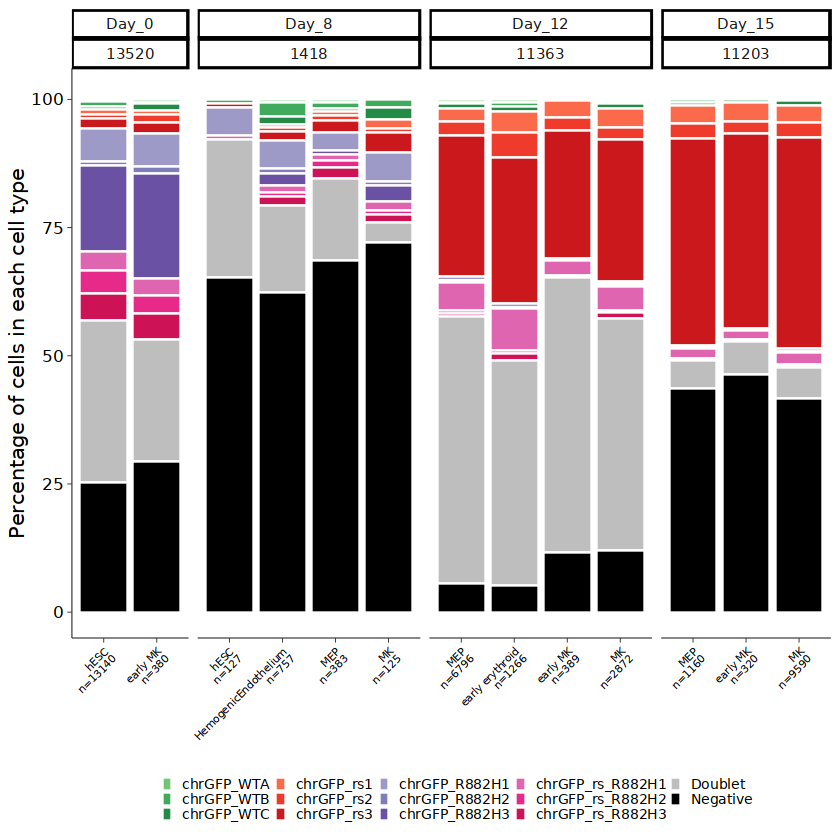

In [246]:
#### Stacked Graph #2---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(current_anot, "\n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(current_anot)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=Assigned_GFPbc_integral)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="Genotype")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(. ~ time_point+ntime, scales='free_x', space='free_x', switch="y", labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime)))+   
    scale_x_discrete(name="current_anot", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=6,vjust=1,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [247]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_time_point_current_anot_vs_Assigned_GFPbc_integral",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png",
        width=12, height=6)
}

## subset for the cells that are genotyped

In [273]:
adata_sub<-subset(adata, Assigned_GFPbc_integral != "Doublet" & Assigned_GFPbc_integral != "Negative")
adata_sub

An object of class Seurat 
445320 features across 16835 samples within 4 assays 
Active assay: SCT (31512 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 3 other assays present: RNA, RNA_raw, ATAC
 7 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, umap.wnn, harmony.rna, harmony.atac

In [274]:
met<-droplevels(adata_sub[[]])

In [275]:
colnames(met)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "gex_raw_reads"                     "gex_mapped_reads"                 
[11] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[13] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[15] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[17] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[19] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[21] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[23] "gex_umis_count"                    "gex_genes_count"                  
[25] "atac_raw_reads"                    "atac_unmapped_reads"              
[27] "atac_lowmapq"                      "atac_dup_reads"                   
[29] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[31] "atac_fragments"                    "atac_TSS_fragments"               
[33] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[35] "TSS.enrichment"                    "TSS.percentile"                   
[37] "scDblFinder.class"                 "scDblFinder.score"                
[39] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[41] "scDblFinder.class_atac"            "scDblFinder.score_atac"           
[43] "scDblFinder.weighted_atac"         "scDblFinder.cxds_score_atac"      
[45] "No_assigned_GFPbc"                 "Assigned_GFPbc"                   
[47] "Assigned_GFPgenotype"              "DBL_comb"                         
[49] "amulet_nFrags"                     "amulet_uniqFrags"                 
[51] "amulet_nAbove2"                    "amulet_total.nAbove2"             
[53] "amulet_p.value"                    "amulet_q.value"                   
[55] "doublet_amulet"                    "nCount_SCT"                       
[57] "nFeature_SCT"                      "SCT.weight"                       
[59] "ATAC.weight"                       "wsnn_res.0.2"                     
[61] "seurat_clusters"                   "doublet"                          
[63] "wsnn_res.2"                        "wsnn_res.0.5"                     
[65] "wsnn_res.0.25"                     "CellTypist_BMA_label"             
[67] "CellTypist_BMA_conf_score"         "CellTypist_IPSCs_label"           
[69] "CellTypist_IPSCs_conf_score"       "CellTypist_BMA_label_filtered"    
[71] "CellTypist_IPSCs_label_filtered"   "time_point"                       
[73] "time"                              "nucleosome_signal"                
[75] "nucleosome_percentile"             "FRiP"                             
[77] "atac_pct_reads_in_peaks"           "my_anot"                          
[79] "FOI"                               "my_anot_updated"                  
[81] "majority_voting_BMA"               "majority_voting_iPSCs"            
[83] "current_anot"                      "Assignation_demux_NO_CB"          
[85] "Assigned_GFPbc_demux_NO_CB"        "Assignation_demux_CB"             
[87] "Assigned_GFPbc_demux_CB"           "Assigned_GFPbc_integral"

In [276]:
met.dt<-data.table(met,key=c("time_point","current_anot","Assigned_GFPbc_integral"))

In [277]:
#str(met.dt)

In [278]:
Freq.table<-as.data.frame(met.dt[,.(Freq=.N),by=key(met.dt)], stringsAsFactors=F)
#Freq.table

In [279]:
met.dt<-data.table(met, key=c("time_point","current_anot"))
Freq.TOTAL<-as.data.frame(met.dt[,.(TOTAL=.N),by=key(met.dt)], stringsAsFactors=F)
#Freq.TOTAL

In [280]:
Freq.table<-merge(Freq.table,
                  Freq.TOTAL,
                  by=c("time_point","current_anot"))
Freq.table$Perc<-round((100*(Freq.table$Freq/Freq.table$TOTAL)),2)

#Freq.table

In [281]:
str(Freq.table)

'data.frame':	155 obs. of  6 variables:
 $ time_point             : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_integral: Ord.factor w/ 12 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                   : int  2 1 5 3 6 8 25 5 78 12 ...
 $ TOTAL                  : int  178 178 178 178 178 178 178 178 178 178 ...
 $ Perc                   : num  1.12 0.56 2.81 1.69 3.37 ...


In [282]:
met.dt<-data.table(met, key=c("time_point"))
Freq.time_point<-as.data.frame(met.dt[,.(ntime=.N),by=key(met.dt)], stringsAsFactors=F)

Freq.table<-merge(Freq.table,
                  Freq.time_point,
                  by="time_point")

#Freq.table

In [283]:
str(Freq.table)

'data.frame':	155 obs. of  7 variables:
 $ time_point             : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_integral: Ord.factor w/ 12 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                   : int  2 1 5 3 6 8 25 5 78 12 ...
 $ TOTAL                  : int  178 178 178 178 178 178 178 178 178 178 ...
 $ Perc                   : num  1.12 0.56 2.81 1.69 3.37 ...
 $ ntime                  : int  5852 5852 5852 5852 5852 5852 5852 5852 5852 5852 ...


In [284]:
Freq.TOTAL<-merge(Freq.TOTAL,
                  Freq.time_point,
                  by="time_point")

In [285]:
Freq.table_filtered<-Freq.table[which(Freq.table$TOTAL >= 50),]

str(Freq.table_filtered)

'data.frame':	118 obs. of  7 variables:
 $ time_point             : Ord.factor w/ 4 levels "Day_0"<"Day_8"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Ord.factor w/ 6 levels "hESC"<"HemogenicEndothelium"<..: 5 5 5 5 5 5 5 5 5 5 ...
 $ Assigned_GFPbc_integral: Ord.factor w/ 12 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Freq                   : int  2 1 5 3 6 8 25 5 78 12 ...
 $ TOTAL                  : int  178 178 178 178 178 178 178 178 178 178 ...
 $ Perc                   : num  1.12 0.56 2.81 1.69 3.37 ...
 $ ntime                  : int  5852 5852 5852 5852 5852 5852 5852 5852 5852 5852 ...


In [286]:
fill_colours<-c(brewer.pal(9, "Greens")[c(5,6,7)],brewer.pal(9, "Reds")[c(5,6,7)],brewer.pal(9, "Purples")[c(5,6,7)],brewer.pal(9, "PuRd")[c(5,6,7)],'gray','black')

In [287]:
library(forcats)
library(cowplot)

-------------------------------------->	0 25 50 75 100


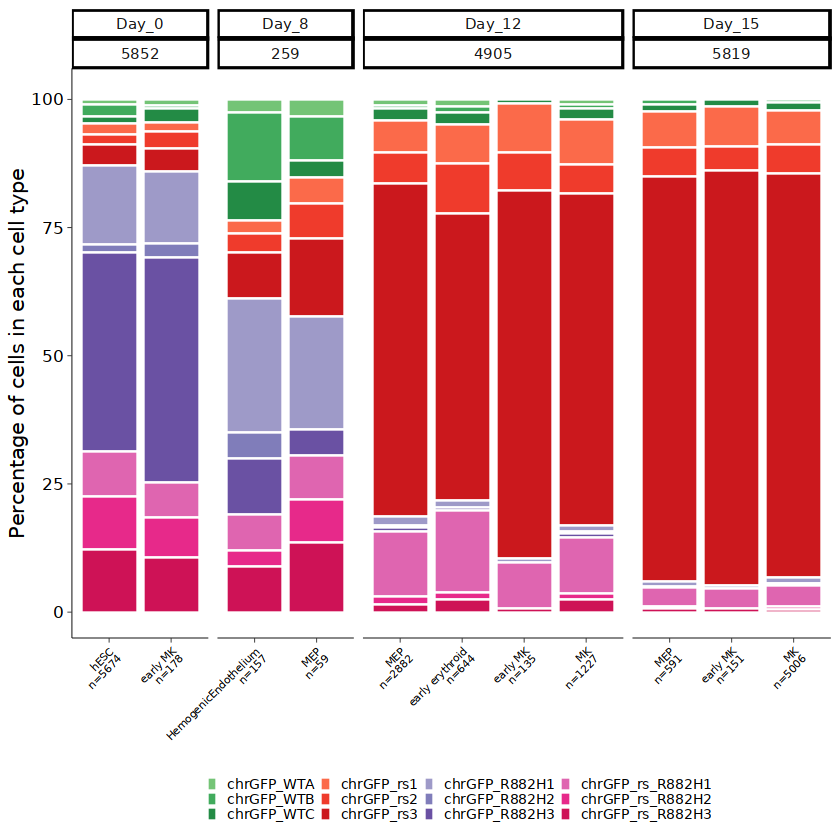

In [288]:
#### Stacked Graph #2---------------
  
  breaks.Rank<-(seq(0,100,by=25))
  labels.Rank<-as.character(breaks.Rank)
  
  cat("-------------------------------------->\t")
  cat(sprintf(as.character(labels.Rank)))
  cat("\n")
  
  
  stacked_barplot<-Freq.table_filtered %>%
    mutate(myaxis = paste0(current_anot, "\n", "n=", TOTAL), drop=F) %>%
    mutate(myaxis=fct_reorder(myaxis,as.numeric(current_anot)), drop=F) %>%
    ggplot(aes(x=myaxis, y=Perc, fill=Assigned_GFPbc_integral)) +
    geom_bar(stat="identity",colour='white')+
    scale_y_continuous(name=paste("Percentage of cells in each cell type",sep=" "),breaks=breaks.Rank,labels=labels.Rank,
                       limits=c(breaks.Rank[1],breaks.Rank[length(breaks.Rank)]+1))+
    scale_fill_manual(values=fill_colours,
                      drop=F,
                      name="integrative assignation")

 stacked_barplot<-stacked_barplot+
    theme_cowplot(font_size = 2)+
    facet_grid(. ~ time_point+ntime, scales='free_x', space='free_x', switch="y", labeller=labeller(paste0(Freq.table_filtered$time_point, "\n", "n=", Freq.table_filtered$ntime)))+   
    scale_x_discrete(name="Seurat clusters", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=6,vjust=1,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="bottom")



stacked_barplot

In [289]:
setwd(path_graphs)

svgname<-paste("stacked_barplot_time_point_current_anot_vs_Assigned_GFPbc_restricted_to_genotyped_cells_integrative_assignation",".png",sep='')
makesvg = TRUE

if (makesvg == TRUE)
{
  ggsave(svgname, plot= stacked_barplot,
         device="png",
        width=12, height=6)
}

# Assess how much noise cell bender corrected per cell type and time point

In [290]:
merged_CB


An object of class Seurat 
12 features across 434347 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [291]:
merged

An object of class Seurat 
12 features across 434347 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [296]:
raw_mat     = GetAssayData(merged, layer = "counts", assay = "RNA")
celb_mat    = GetAssayData(merged_CB, layer = "counts", assay = "RNA")

In [297]:
str(raw_mat)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:1012499] 4 0 6 8 9 10 11 6 2 10 ...
  ..@ p       : int [1:434348] 0 0 1 6 7 7 8 10 11 12 ...
  ..@ Dim     : int [1:2] 12 434347
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:434347] "MCO_01326_AAACAGCCAAAGCCTC-1" "MCO_01326_AAACAGCCAAAGGTAC-1" "MCO_01326_AAACAGCCAAATACCT-1" "MCO_01326_AAACAGCCAACACCTA-1" ...
  ..@ x       : num [1:1012499] 1 1 1 1 1 1 1 1 1 2 ...
  ..@ factors : list()


In [298]:
str(celb_mat)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:149215] 4 5 6 7 8 9 10 6 8 9 ...
  ..@ p       : int [1:434348] 0 0 0 0 0 0 0 0 0 0 ...
  ..@ Dim     : int [1:2] 12 434347
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:434347] "MCO_01326_AAACAGCCAAAGCCTC-1" "MCO_01326_AAACAGCCAAAGGTAC-1" "MCO_01326_AAACAGCCAAATACCT-1" "MCO_01326_AAACAGCCAACACCTA-1" ...
  ..@ x       : num [1:149215] 1 1 1 1 17 1 1 1 26 2 ...
  ..@ factors : list()


In [299]:
fract       = celb_mat/raw_mat

In [300]:
str(fract)

Formal class 'dgeMatrix' [package "Matrix"] with 4 slots
  ..@ Dim     : int [1:2] 12 434347
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:12] "GFP-chrGFP-WTA" "GFP-chrGFP-WTB" "GFP-chrGFP-WTC" "GFP-chrGFP-rs1" ...
  .. ..$ : chr [1:434347] "MCO_01326_AAACAGCCAAAGCCTC-1" "MCO_01326_AAACAGCCAAAGGTAC-1" "MCO_01326_AAACAGCCAAATACCT-1" "MCO_01326_AAACAGCCAACACCTA-1" ...
  ..@ x       : num [1:5212164] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  ..@ factors : list()


In [302]:
means       = rowMeans(fract, na.rm=T)
means


GFP-chrGFP-WTA       GFP-chrGFP-WTB       GFP-chrGFP-WTC 
          0.20052531           0.14246040           0.18030934 
      GFP-chrGFP-rs1       GFP-chrGFP-rs2       GFP-chrGFP-rs3 
          0.13526073           0.13491230           0.07855243 
   GFP-chrGFP-R882H1    GFP-chrGFP-R882H2    GFP-chrGFP-R882H3 
          0.09903354           0.14746417           0.09302663 
GFP-chrGFP-rs-R882H1 GFP-chrGFP-rs-R882H2 GFP-chrGFP-rs-R882H3 
          0.10433289           0.11755499           0.11528780

In [303]:
  CB_correction = CreateSeuratObject(counts = fract)


Warning message:
"Data is of class dgeMatrix. Coercing to dgCMatrix."


In [304]:
CB_correction

An object of class Seurat 
12 features across 434347 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [305]:
str(row.names(CB_correction@meta.data))

 chr [1:434347] "MCO_01326_AAACAGCCAAAGCCTC-1" ...


## Only use the barcodes that are part of my final object

In [306]:
joint.bcs <- intersect(colnames(adata), colnames(CB_correction))

str(joint.bcs)

 chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" ...


In [307]:
CB_correction_restricted <- subset(CB_correction, cells = joint.bcs)

CB_correction_restricted

An object of class Seurat 
12 features across 37492 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [308]:
colnames(adata@meta.data)

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_RNA_raw"                    "nFeature_RNA_raw"                 
 [7] "nCount_ATAC"                       "nFeature_ATAC"                    
 [9] "gex_raw_reads"                     "gex_mapped_reads"                 
[11] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[13] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[15] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[17] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[19] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[21] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[23] "gex_umis_count"                    "gex_genes_count"                  
[25] "atac_raw_reads"                    "atac_unmapped_reads"              
[27] "atac_lowmapq"                      "atac_dup_reads"                   
[29] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[31] "atac_fragments"                    "atac_TSS_fragments"               
[33] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[35] "TSS.enrichment"                    "TSS.percentile"                   
[37] "scDblFinder.class"                 "scDblFinder.score"                
[39] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[41] "scDblFinder.class_atac"            "scDblFinder.score_atac"           
[43] "scDblFinder.weighted_atac"         "scDblFinder.cxds_score_atac"      
[45] "No_assigned_GFPbc"                 "Assigned_GFPbc"                   
[47] "Assigned_GFPgenotype"              "DBL_comb"                         
[49] "amulet_nFrags"                     "amulet_uniqFrags"                 
[51] "amulet_nAbove2"                    "amulet_total.nAbove2"             
[53] "amulet_p.value"                    "amulet_q.value"                   
[55] "doublet_amulet"                    "nCount_SCT"                       
[57] "nFeature_SCT"                      "SCT.weight"                       
[59] "ATAC.weight"                       "wsnn_res.0.2"                     
[61] "seurat_clusters"                   "doublet"                          
[63] "wsnn_res.2"                        "wsnn_res.0.5"                     
[65] "wsnn_res.0.25"                     "CellTypist_BMA_label"             
[67] "CellTypist_BMA_conf_score"         "CellTypist_IPSCs_label"           
[69] "CellTypist_IPSCs_conf_score"       "CellTypist_BMA_label_filtered"    
[71] "CellTypist_IPSCs_label_filtered"   "time_point"                       
[73] "time"                              "nucleosome_signal"                
[75] "nucleosome_percentile"             "FRiP"                             
[77] "atac_pct_reads_in_peaks"           "my_anot"                          
[79] "FOI"                               "my_anot_updated"                  
[81] "majority_voting_BMA"               "majority_voting_iPSCs"            
[83] "current_anot"                      "Assignation_demux_NO_CB"          
[85] "Assigned_GFPbc_demux_NO_CB"        "Assignation_demux_CB"             
[87] "Assigned_GFPbc_demux_CB"           "Assigned_GFPbc_integral"

## Add metadata from adata

In [309]:
CB_correction_restricted<-AddMetaData(object= CB_correction_restricted,
                  metadata= adata@meta.data$time_point,
                  col.name = "time_point")

In [310]:
CB_correction_restricted<-AddMetaData(object= CB_correction_restricted,
                  metadata= adata@meta.data$current_anot,
                  col.name = "current_anot")

In [311]:
CB_correction_restricted<-AddMetaData(object= CB_correction_restricted,
                  metadata= adata@meta.data$Assigned_GFPbc_integral,
                  col.name = "Assigned_GFPbc_integral")

In [312]:
CB_correction_restricted

An object of class Seurat 
12 features across 37492 samples within 1 assay 
Active assay: RNA (12 features, 0 variable features)
 1 layer present: counts

In [314]:
barcodes<-Features(CB_correction_restricted)

In [319]:
barcodes

[1] "GFP-chrGFP-WTA"       "GFP-chrGFP-WTB"       "GFP-chrGFP-WTC"      
 [4] "GFP-chrGFP-rs1"       "GFP-chrGFP-rs2"       "GFP-chrGFP-rs3"      
 [7] "GFP-chrGFP-R882H1"    "GFP-chrGFP-R882H2"    "GFP-chrGFP-R882H3"   
[10] "GFP-chrGFP-rs-R882H1" "GFP-chrGFP-rs-R882H2" "GFP-chrGFP-rs-R882H3"

In [325]:
corrections    = as.data.frame(t(GetAssayData(CB_correction_restricted, layer = "counts", assay = "RNA")))

str(corrections)
str(row.names(corrections))

'data.frame':	37492 obs. of  12 variables:
 $ GFP-chrGFP-WTA      : num  NaN NaN 0 NaN NaN NaN NaN 0 NaN 0 ...
 $ GFP-chrGFP-WTB      : num  NaN NaN 0 0 NaN NaN NaN 0 0.5 NaN ...
 $ GFP-chrGFP-WTC      : num  NaN NaN NaN 0 0 NaN NaN NaN NaN 0.5 ...
 $ GFP-chrGFP-rs1      : num  0 NaN 0 NaN 1 0 0 NaN 0 0 ...
 $ GFP-chrGFP-rs2      : num  NaN NaN NaN 0 0 NaN NaN 0 NaN NaN ...
 $ GFP-chrGFP-rs3      : num  0 NaN 0 NaN 0 ...
 $ GFP-chrGFP-R882H1   : num  0.333 NaN 0 0 0 ...
 $ GFP-chrGFP-R882H2   : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ GFP-chrGFP-R882H3   : num  0.929 0 0 0 0.333 ...
 $ GFP-chrGFP-rs-R882H1: num  0.667 NaN 0 0 0 ...
 $ GFP-chrGFP-rs-R882H2: num  0.5 0 0 0 0 ...
 $ GFP-chrGFP-rs-R882H3: num  0.333 0 0 0 NaN ...
 chr [1:37492] "MCO_01326_AAACAGCCACAGCCAT-1" ...


In [326]:
corrections$CellID<-row.names(corrections)

In [327]:
met<-CB_correction_restricted@meta.data

In [328]:
met$CellID<-row.names(met)

In [329]:
str(met)

'data.frame':	37492 obs. of  7 variables:
 $ orig.ident             : Factor w/ 1 level "MCO": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA             : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ nFeature_RNA           : int  NA NA NA NA NA NA NA NA NA NA ...
 $ time_point             : Factor w/ 4 levels "Day_0","Day_8",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot           : Factor w/ 6 levels "hESC","HemogenicEndothelium",..: 1 1 1 5 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_integral: Factor w/ 14 levels "chrGFP_WTA","chrGFP_WTB",..: 9 14 14 14 4 14 7 14 13 7 ...
 $ CellID                 : chr  "MCO_01326_AAACAGCCACAGCCAT-1" "MCO_01326_AAACAGCCACCAGGTT-1" "MCO_01326_AAACAGCCACGGTACT-1" "MCO_01326_AAACAGCCAGCCGCTA-1" ...


In [330]:
corrections<-merge(corrections, met, by="CellID")

In [331]:
str(corrections)

'data.frame':	37492 obs. of  19 variables:
 $ CellID                 : chr  "MCO_01326_AAACAGCCACAGCCAT-1" "MCO_01326_AAACAGCCACCAGGTT-1" "MCO_01326_AAACAGCCACGGTACT-1" "MCO_01326_AAACAGCCAGCCGCTA-1" ...
 $ GFP-chrGFP-WTA         : num  NaN NaN 0 NaN NaN NaN NaN 0 NaN 0 ...
 $ GFP-chrGFP-WTB         : num  NaN NaN 0 0 NaN NaN NaN 0 0.5 NaN ...
 $ GFP-chrGFP-WTC         : num  NaN NaN NaN 0 0 NaN NaN NaN NaN 0.5 ...
 $ GFP-chrGFP-rs1         : num  0 NaN 0 NaN 1 0 0 NaN 0 0 ...
 $ GFP-chrGFP-rs2         : num  NaN NaN NaN 0 0 NaN NaN 0 NaN NaN ...
 $ GFP-chrGFP-rs3         : num  0 NaN 0 NaN 0 ...
 $ GFP-chrGFP-R882H1      : num  0.333 NaN 0 0 0 ...
 $ GFP-chrGFP-R882H2      : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ GFP-chrGFP-R882H3      : num  0.929 0 0 0 0.333 ...
 $ GFP-chrGFP-rs-R882H1   : num  0.667 NaN 0 0 0 ...
 $ GFP-chrGFP-rs-R882H2   : num  0.5 0 0 0 0 ...
 $ GFP-chrGFP-rs-R882H3   : num  0.333 0 0 0 NaN ...
 $ orig.ident             : Factor w/ 1 level "MCO": 1 1

In [333]:
indx.to.melt<-grep("^GFP-",colnames(corrections))
indx.to.melt

[1]  2  3  4  5  6  7  8  9 10 11 12 13

In [334]:
corrections.m<-melt(corrections, id.vars=colnames(corrections)[-indx.to.melt], variable.name="barcode", value.name="percent_of_original_value")

str(corrections.m)

Warning message in melt(corrections, id.vars = colnames(corrections)[-indx.to.melt], :
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(corrections). In the next version, this warning will become an error."


'data.frame':	449904 obs. of  9 variables:
 $ CellID                   : chr  "MCO_01326_AAACAGCCACAGCCAT-1" "MCO_01326_AAACAGCCACCAGGTT-1" "MCO_01326_AAACAGCCACGGTACT-1" "MCO_01326_AAACAGCCAGCCGCTA-1" ...
 $ orig.ident               : Factor w/ 1 level "MCO": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA               : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ nFeature_RNA             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ time_point               : Factor w/ 4 levels "Day_0","Day_8",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot             : Factor w/ 6 levels "hESC","HemogenicEndothelium",..: 1 1 1 5 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_integral  : Factor w/ 14 levels "chrGFP_WTA","chrGFP_WTB",..: 9 14 14 14 4 14 7 14 13 7 ...
 $ barcode                  : Factor w/ 12 levels "GFP-chrGFP-WTA",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ percent_of_original_value: num  NaN NaN 0 NaN NaN NaN NaN 0 NaN 0 ...


In [335]:
corrections.m$barcode<-gsub("^GFP-","",corrections.m$barcode)
corrections.m$barcode<-gsub("-","_",corrections.m$barcode)

In [337]:
summary(as.factor(corrections.m$barcode))

chrGFP_R882H1    chrGFP_R882H2    chrGFP_R882H3 chrGFP_rs_R882H1 
           37492            37492            37492            37492 
chrGFP_rs_R882H2 chrGFP_rs_R882H3       chrGFP_rs1       chrGFP_rs2 
           37492            37492            37492            37492 
      chrGFP_rs3       chrGFP_WTA       chrGFP_WTB       chrGFP_WTC 
           37492            37492            37492            37492

In [338]:
corrections.m$barcode<-factor(corrections.m$barcode,
                                       levels = c("chrGFP_WTA","chrGFP_WTB","chrGFP_WTC",
                                                  "chrGFP_rs1","chrGFP_rs2","chrGFP_rs3",
                                                  "chrGFP_R882H1","chrGFP_R882H2","chrGFP_R882H3",
                                                  "chrGFP_rs_R882H1","chrGFP_rs_R882H2","chrGFP_rs_R882H3","Doublet","Negative"),
                                       ordered=T)

In [339]:
summary(corrections.m$barcode)

chrGFP_WTA       chrGFP_WTB       chrGFP_WTC       chrGFP_rs1 
           37492            37492            37492            37492 
      chrGFP_rs2       chrGFP_rs3    chrGFP_R882H1    chrGFP_R882H2 
           37492            37492            37492            37492 
   chrGFP_R882H3 chrGFP_rs_R882H1 chrGFP_rs_R882H2 chrGFP_rs_R882H3 
           37492            37492            37492            37492 
         Doublet         Negative 
               0                0

In [341]:
corrections.m$barcode<-droplevels(corrections.m$barcode)

In [342]:
str(corrections.m)

'data.frame':	449904 obs. of  9 variables:
 $ CellID                   : chr  "MCO_01326_AAACAGCCACAGCCAT-1" "MCO_01326_AAACAGCCACCAGGTT-1" "MCO_01326_AAACAGCCACGGTACT-1" "MCO_01326_AAACAGCCAGCCGCTA-1" ...
 $ orig.ident               : Factor w/ 1 level "MCO": 1 1 1 1 1 1 1 1 1 1 ...
 $ nCount_RNA               : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ nFeature_RNA             : int  NA NA NA NA NA NA NA NA NA NA ...
 $ time_point               : Factor w/ 4 levels "Day_0","Day_8",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ current_anot             : Factor w/ 6 levels "hESC","HemogenicEndothelium",..: 1 1 1 5 1 1 1 1 1 1 ...
 $ Assigned_GFPbc_integral  : Factor w/ 14 levels "chrGFP_WTA","chrGFP_WTB",..: 9 14 14 14 4 14 7 14 13 7 ...
 $ barcode                  : Ord.factor w/ 12 levels "chrGFP_WTA"<"chrGFP_WTB"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ percent_of_original_value: num  NaN NaN 0 NaN NaN NaN NaN 0 NaN 0 ...


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
Warning message:
"Removed 212365 rows containing non-finite values (`stat_ydensity()`)."


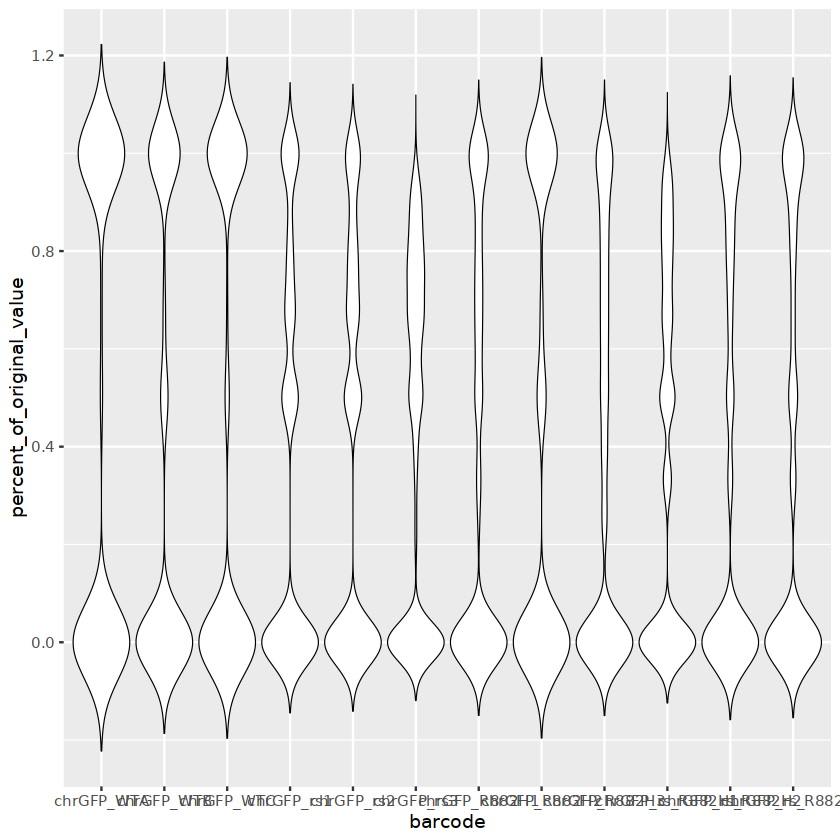

In [343]:
 violin_plot<-ggplot(data=corrections.m,
                aes(x=barcode, y=percent_of_original_value))+
    geom_violin(scale = "width", adjust = 1, trim = FALSE, linetype = "solid", size=0.25, color='black', fill='white')





   violin_plot
   




Warning message:
"Removed 212365 rows containing non-finite values (`stat_ydensity()`)."


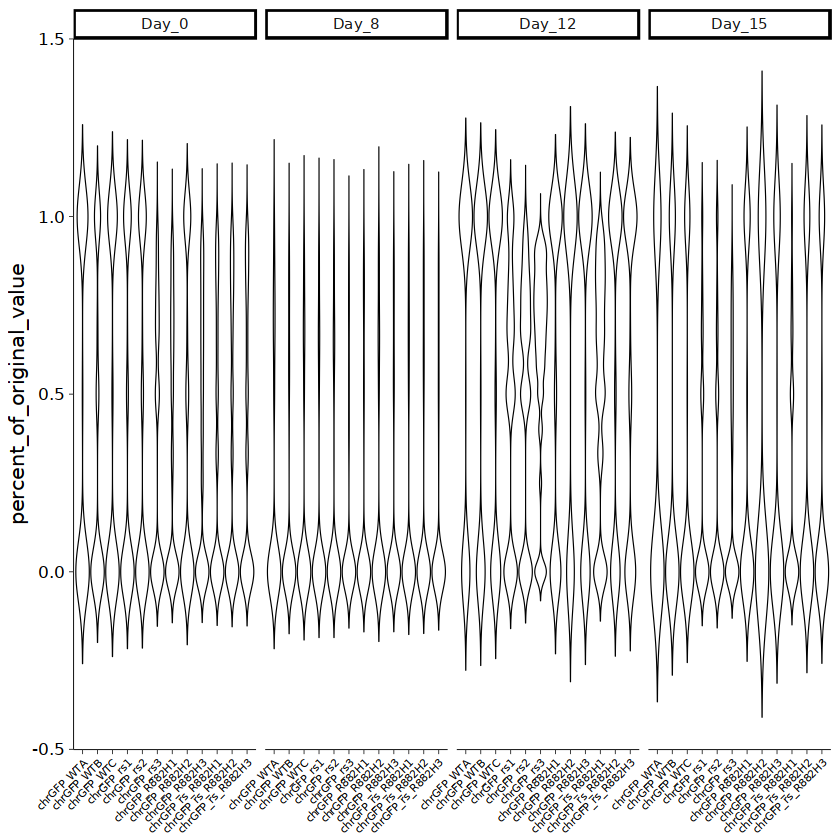

In [344]:
violin_plot<-violin_plot+
    theme_cowplot(font_size = 2)+
    facet_grid(. ~ time_point, scales='free_x', space='free_x', switch="y")+   
    scale_x_discrete(name="Barcode", drop=T)+
    theme( strip.background = element_blank(),
           strip.placement = "outside",
           strip.text = element_text(size=6),
           panel.spacing = unit(0.2, "lines"),
           panel.background=element_rect(fill="white"),
           panel.border=element_rect(colour="white",size=0,5),
           panel.grid.major = element_blank(),
           panel.grid.minor = element_blank())+
        theme_classic()+
            theme(axis.title.y=element_text(size=12, color="black", family="sans"),
                  axis.title.x=element_blank(),
                  axis.text.y=element_text(angle=0,size=10, color="black", family="sans"),
                  axis.text.x=element_text(angle=45,size=6,vjust=1,hjust=1,color="black", family="sans"),
                  axis.line.x = element_line(size = 0.2),
                  axis.ticks.x = element_line(size = 0.2),
                  axis.ticks.y = element_line(size = 0.2),
                  axis.line.y = element_line(size = 0.2))+
            theme(legend.title = element_blank(),
                  legend.text = element_text(size=8, color="black", family="sans"),
                  legend.key.size = unit(0.25, 'cm'), #change legend key size
                  legend.key.height = unit(0.25, 'cm'), #change legend key height
                  legend.key.width = unit(0.25, 'cm'), #change legend key width
                  legend.position="none")

violin_plot

# Save the new object

In [345]:
setwd("/group/soranzo/manuel.tardaguila/2025_hESC_MK_multiome/processing_outputs/")

saveRDS(adata, file="merged_processed_presentation_updated_integrative_genotyping.rds")